In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib as mpl
from collections import defaultdict

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
# configure matplotlib
%matplotlib notebook
# %matplotlib inline

In [3]:
#mpl.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
mpl.rc('font',**{'family':'serif'})
mpl.rc('text', usetex=True)

In [4]:
from cdi.util.stats_utils import load_statistics

from cdi.util.analysis.plotting import plot_comparison, plot_seaborn_comparison
from cdi.util.analysis.logs import collate_stats

## Analysis setup

### Global settings

In [6]:
data_name = 'toy_set3_mar'
# exp_seed_key = 'm20190508_d20200325_20200406_20200407'
exp_seed_keys = [
    'm20190508_d20200325_20200406_20200407',
    'm20190508_d2020032511_20200406_20200407',
    'm20190508_d2020032522_20200406_20200407'
]

### Templates

In [7]:
log_path_template = f'../../trained_models/{data_name}/learning_experiments/{{}}/{{}}/{{}}/logs/{{}}'

## Helpers

In [8]:
def read_experiment_stats(group, model, seed, filename):
    path = log_path_template.format(group, model, seed, filename)
    filename = os.path.basename(path)
    dirpath = os.path.dirname(path)
    return load_statistics(dirpath, filename)

def read_experiment_stats_all_seeds(group, model, filename):
    all_stats = defaultdict(list)
    for exp_seed in exp_seed_keys:
        path = log_path_template.format(group, model, exp_seed, filename)
        filename = os.path.basename(path)
        dirpath = os.path.dirname(path)
        stats = load_statistics(dirpath, filename)
        for k, v in stats.items():
            all_stats[k].append(v)
    
    return all_stats

def read_suite_stats_all_seeds(group, suite, filename):
    return {
        name: read_experiment_stats_all_seeds(group, model, filename)
        for name, model in suite.items()
    }

def read_suite_stats(group, suite, filename, seed):
    return {
        name: read_experiment_stats(group, model, seed, filename)
        for name, model in suite.items()
    }

def read_suite_stats_with_init_all_seeds(group, suite):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats_all_seeds(group, model, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, exp_seed_keys[0], 'init_summary.csv')):
            init_stats = read_experiment_stats_all_seeds(group, model, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

def read_suite_stats_with_init(group, suite, seed):
    stats = {}
    for name, model in suite.items():
        stats[name] = read_experiment_stats(group, model, seed, 'summary.csv')
        # Please ignore this ugliness it just appends the initialisation stats to the experiment stats
        if os.path.exists(log_path_template.format(group, model, seed, 'init_summary.csv')):
            init_stats = read_experiment_stats(group, model, seed, 'init_summary.csv')
            stats[name]['init'] = init_stats

    return stats

##

def read_all_suite_stats(groups, suite, filename, seed):
    return {
        group: read_suite_stats(group, suite, filename, seed)
        for group in groups
    }


## Learning curve analysis

### Likelihood analysis


#### Log-likelihood vs epoch

In [19]:
suite = {
    'Complete MLE': 'fa_complete_data_test',
    'Emp. imp. base MI5': 'fa_empirical_sample_baseline_test',
    'MICE': 'fa_mice_baseline_test',
    'VCDI 1mis': 'fa_pretrained_var_cdi_1mis_3gibbs_test',
#     'VCDI all\_mis': 'fa_pretrained_var_cdi_all_mis_1gibbs_test',
}

##### Single experiment

<IPython.core.display.Javascript object>


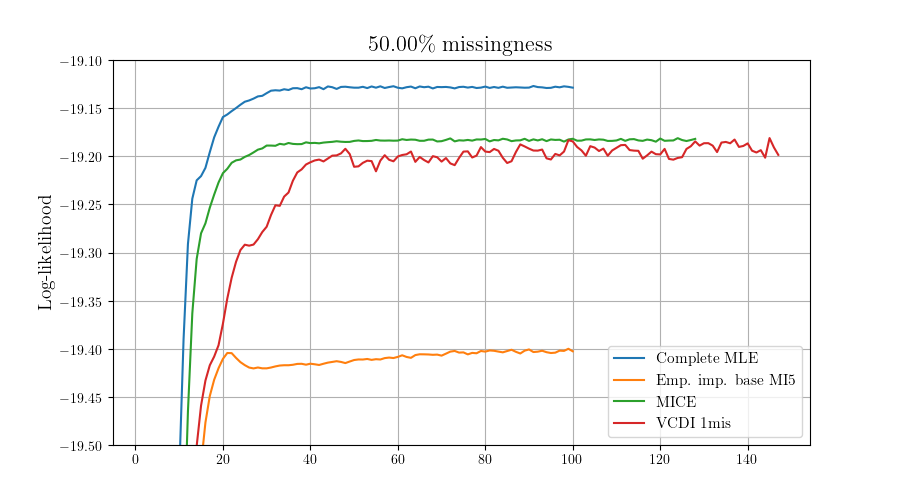

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(9, 5))
axes = [axes]
for i, g in enumerate([3]):
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel='Epoch'
    else:
        xlabel=None
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('val_log_lik',),  
# #                     y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),
                    err_keys=(None,),
#                     err_keys=(None, None),
#                     err_keys=(None, None, None),
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.5, -19.1))

# axes[0].set_xlim(left=-5, right=255)
# axes[1].set_xlim(left=-5, right=255)
# axes[2].set_xlim(left=-5, right=255)

##### Avg. over seeds

<IPython.core.display.Javascript object>


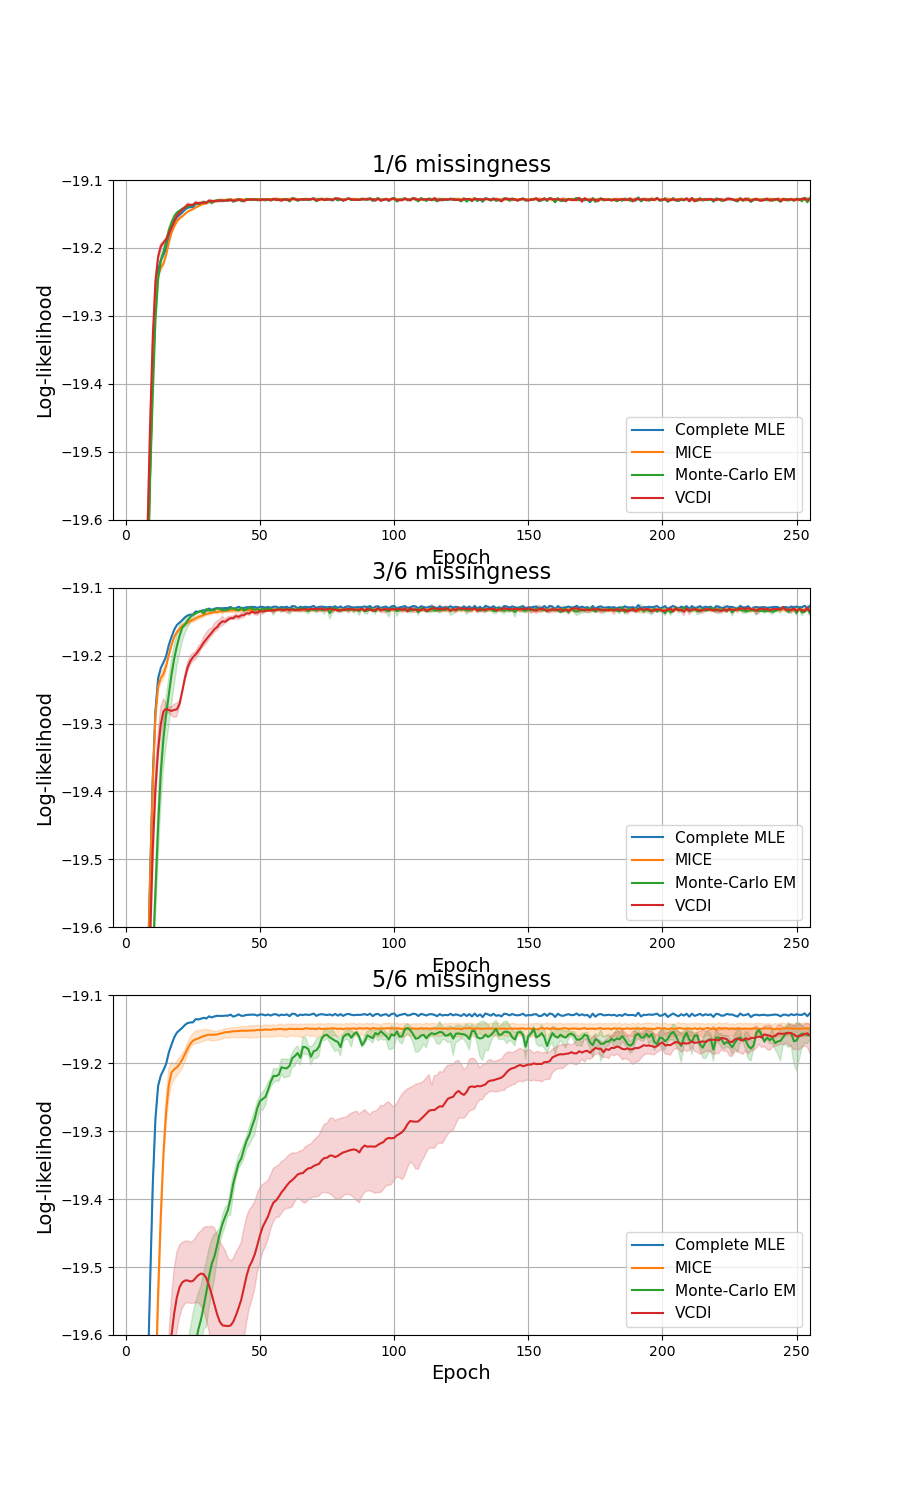

(-5.0, 255.0)

In [10]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 15))
# axes = [axes]
for i, g in enumerate([1, 3, 5]):
    stats = read_suite_stats_all_seeds(group=g, suite=suite, filename='summary.csv')

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel='Epoch'
    else:
        xlabel=None
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('val_log_lik',),
                    xlabel='Epoch',
                    ylabel='Log-likelihood', 
#                     ylim=None)
                    ylim=(-19.6, -19.1))
#                     ylim=(-26, -17))
#                     ylim=(0, 10))

axes[0].set_xlim(left=-5, right=255)
axes[1].set_xlim(left=-5, right=255)
axes[2].set_xlim(left=-5, right=255)

#### Log-likelihood vs # $p(x)$ evaluations

In [81]:
suite = {
    'Complete + MLE': 'fa_complete_data',
    'Emp. imputation + MLE': 'fa_empirical_sample_baseline_mi5',
#     'Reg. imp. base': 'fa_regression_baseline',
    'MICE + MLE': 'fa_mice_baseline_mi5',
#     'MICE MI1 base': 'fa_mice_baseline_mi1',
#     'EM (indep)': 'fa_em_indep',
    'Monte-Carlo EM': 'fa_em_joint',
#     'CDI MI5': 'fa_exact_gibbs_posterior_cdi_mi5',
#     'VCDI MI5': 'fa_variational_cdi_mi5',
#     'VCDI mixed test': 'fa_var_cdi_mixed_test',
#     'pre-VCDI MI5 1mis 1gibbs': 'fa_pretrained_var_cdi_mi5_1mis_1gibbs',
    'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs', #'pre-VCDI MI5 1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
    'VCDI (old)': 'bck_posterior_effects_analysis/fa_pretrained_var_cdi_mi5_1mis_3gibbs', #'pre-VCDI MI5 1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
    'VCDI (test)': 'fa_pretrained_var_cdi_1mis_3gibbs_test',
#     'pre-VCDI MI5 all-miss 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
#     'pre-VCDI MI1 1mis 1gibbs': 'fa_pretrained_var_cdi_mi1_1mis_1gibbs',
#     'pre-VCDI MI1 1mis 3gibbs': 'fa_pretrained_var_cdi_mi1_1mis_3gibbs',
#     'pre-VCDI MI1 all-miss 1gibbs': 'fa_pretrained_var_cdi_mi1_all_mis_1gibbs',
#     'pre-VCI MI5 1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
#     'pre-VCI MI5 05all 3gibbs s3': 'fa_pretrained_var_cdi_mi5_05all_3gibbs_s3',
#     'VCDIEM (test) 1mis': 'fa_pretrained_var_cdiem_1mis_3gibbs_test',
#     'VCDIEM (test) 1all': 'fa_pretrained_var_cdiem_1all_3gibbs_test',
}

##### Single experiment

<IPython.core.display.Javascript object>


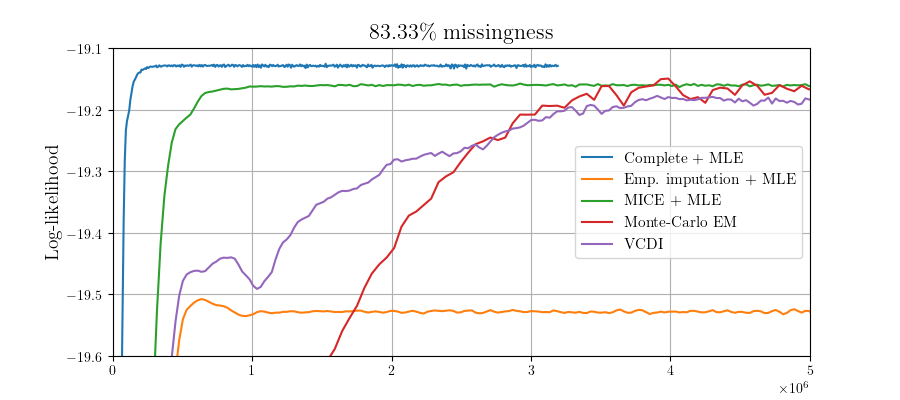

(-10.0, 5000010.0)

In [82]:
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(9, 4))
axes = [axes]
for i, g in enumerate([5]):
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')
    for exp, metrics in stats.items():
        metrics['cum_fa_calls'] = np.cumsum(metrics['cum_fa_calls'])
#         metrics['cum_var_calls'] = np.cumsum(metrics['cum_var_calls'])

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel = '\# samples evaluated on $p(x)$'
    else:
        xlabel = None
    plot_comparison(axes[i], stats, 
                    x_metric_key='cum_fa_calls',
                    y_metric_keys=('val_log_lik',),  
# #                     y_metric_keys=('train_log_lik', 'train_entropy', 'val_log_lik'),
                    err_keys=(None,),
#                     err_keys=(None, None),
#                     err_keys=(None, None, None),
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
#                     ylim=None)
                    ylim=(-19.6, -19.1))
#                     ylim=(-26, -17))
#                     ylim=(0, 10))

axes[0].set_xlim(left=-10, right=5e6+10)
# axes[1].set_xlim(left=-10, right=5e6+10)
# axes[2].set_xlim(left=-10, right=5e6+10)

##### Avg. over seeds

<IPython.core.display.Javascript object>


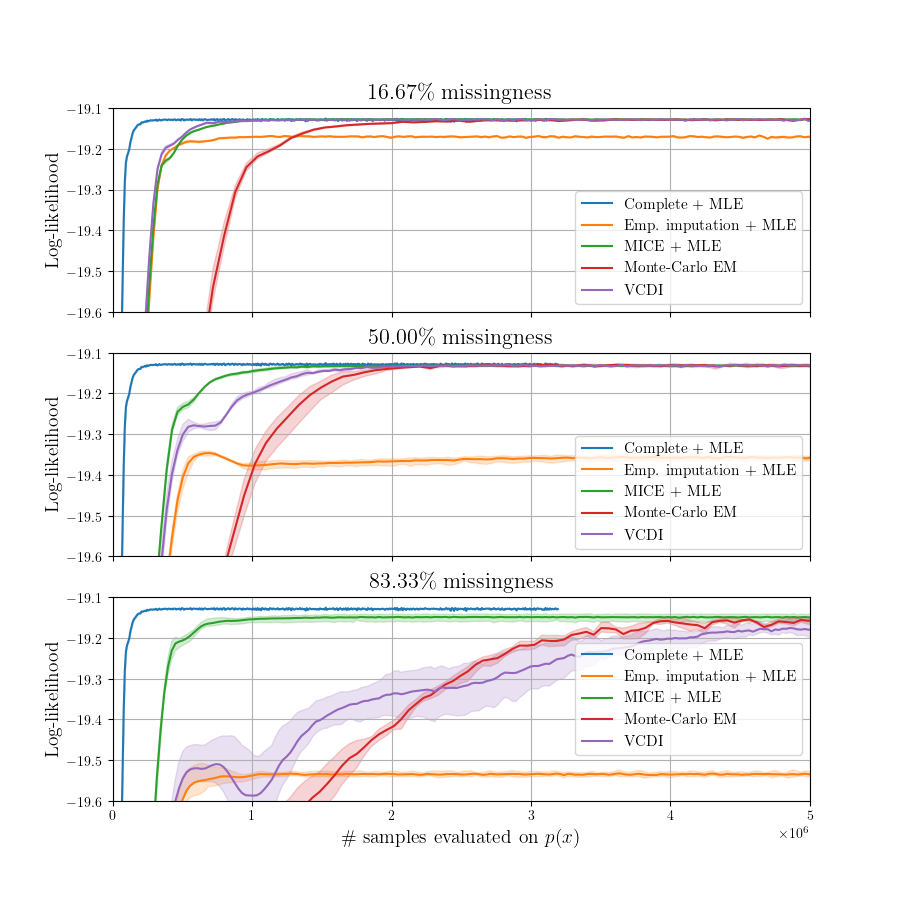

(-10.0, 5000010.0)

In [83]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, sharex=True, figsize=(9, 9))
# axes = [axes]
for i, g in enumerate([1, 3, 5]):
    stats = read_suite_stats_all_seeds(group=g, suite=suite, filename='summary.csv')
    for exp, metrics in stats.items():
        for j in range(len(metrics['cum_fa_calls'])):
            metrics['cum_fa_calls'][j] = np.cumsum(metrics['cum_fa_calls'][j])
        mean_cum_sum = np.mean(np.stack(metrics['cum_fa_calls']), axis=0)
        for j in range(len(metrics['cum_fa_calls'])):
            metrics['cum_fa_calls'][j] = mean_cum_sum

    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    if i in (2,):
        xlabel = '\# samples evaluated on $p(x)$'
    else:
        xlabel = None
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='cum_fa_calls',
                    y_metric_keys=('val_log_lik',),  
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
#                     ylim=None)
                    ylim=(-19.6, -19.1))
#                     ylim=(-26, -17))

axes[0].set_xlim(left=-10, right=5e6+10)
axes[1].set_xlim(left=-10, right=5e6+10)
axes[2].set_xlim(left=-10, right=5e6+10)


In [84]:
# fig.savefig('figures/toy_mcar_learning_curves_vs_num_px.pdf', bbox_inches='tight')

#### Log-likelihood vs time

In [14]:
suite = {
    'Complete MLE': 'fa_complete_data',
#     'Emp. imp. base MI5': 'fa_empirical_sample_baseline_mi5',
#     'Reg. imp. base': 'fa_regression_baseline',
    'MICE': 'fa_mice_baseline_mi5',
#     'MICE MI1 base': 'fa_mice_baseline_mi1',
#     'EM (indep)': 'fa_em_indep',
    'Monte-Carlo EM': 'fa_em_joint',
#     'CDI MI5': 'fa_exact_gibbs_posterior_cdi_mi5',
#     'VCDI MI5': 'fa_variational_cdi_mi5',
#     'VCDI mixed test': 'fa_var_cdi_mixed_test',
#     'pre-VCDI MI5 1mis 1gibbs': 'fa_pretrained_var_cdi_mi5_1mis_1gibbs',
    'VCDI': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs', #'pre-VCDI MI5 1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
#     'pre-VCDI MI5 all-miss 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
#     'pre-VCDI MI1 1mis 1gibbs': 'fa_pretrained_var_cdi_mi1_1mis_1gibbs',
#     'pre-VCDI MI1 1mis 3gibbs': 'fa_pretrained_var_cdi_mi1_1mis_3gibbs',
#     'pre-VCDI MI1 all-miss 1gibbs': 'fa_pretrained_var_cdi_mi1_all_mis_1gibbs',
#     'pre-VCI MI5 1all 3gibbs': 'fa_pretrained_var_cdi_mi5_1all_3gibbs',
#     'pre-VCI MI5 05all 3gibbs s3': 'fa_pretrained_var_cdi_mi5_05all_3gibbs_s3',

}

##### Single experiment

<IPython.core.display.Javascript object>


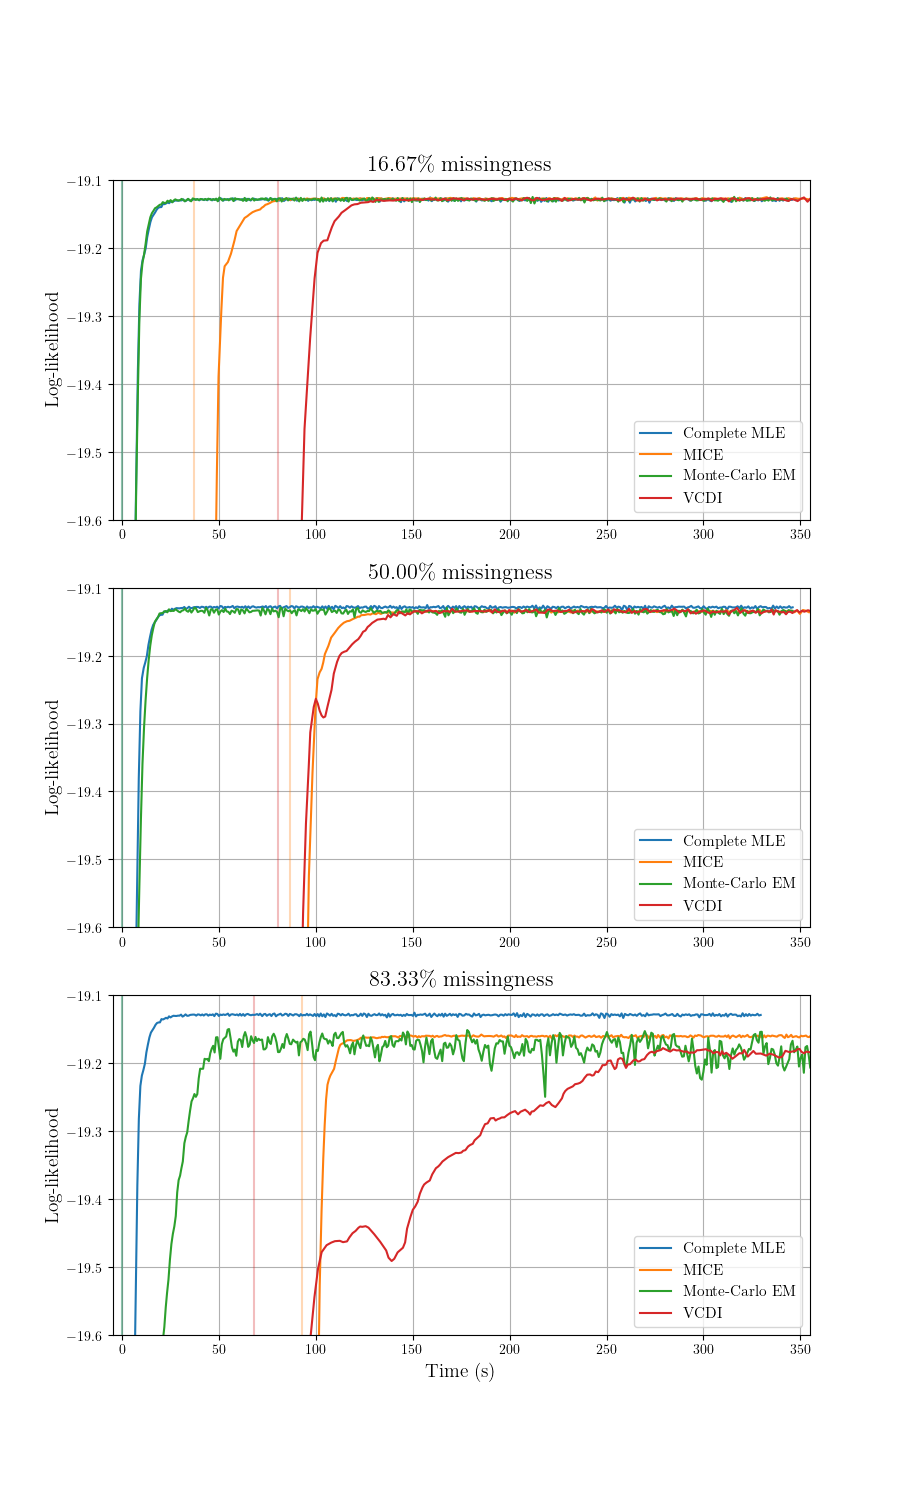

(-5.0, 355.0)

In [11]:
y_metrics = ('val_log_lik',)

fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 15))
# axes = [axes]
for i, g in enumerate([1, 3, 5]):
    stats = read_suite_stats_with_init(group=g, suite=suite, seed=exp_seed_keys[0])
    v_lines = {}
    for exp, metrics in stats.items():
        metrics['train_time'] = np.cumsum(metrics['train_time'])
        if 'init_time' in metrics['init']:
            init_time = np.sum(metrics['init']['init_time'])
            metrics['train_time'] += init_time
            v_lines[exp] = init_time
        else:
            v_lines[exp] = None

    if i in (2,):
        xlabel = 'Time (s)'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_comparison(axes[i], stats, 
                    x_metric_key='train_time',
                    y_metric_keys=y_metrics,  
                    err_keys=(None, ),
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.6, -19.1))

axes[0].set_xlim(left=-5, right=355)
axes[1].set_xlim(left=-5, right=355)
axes[2].set_xlim(left=-5, right=355)

##### Avg. over seeds

<IPython.core.display.Javascript object>


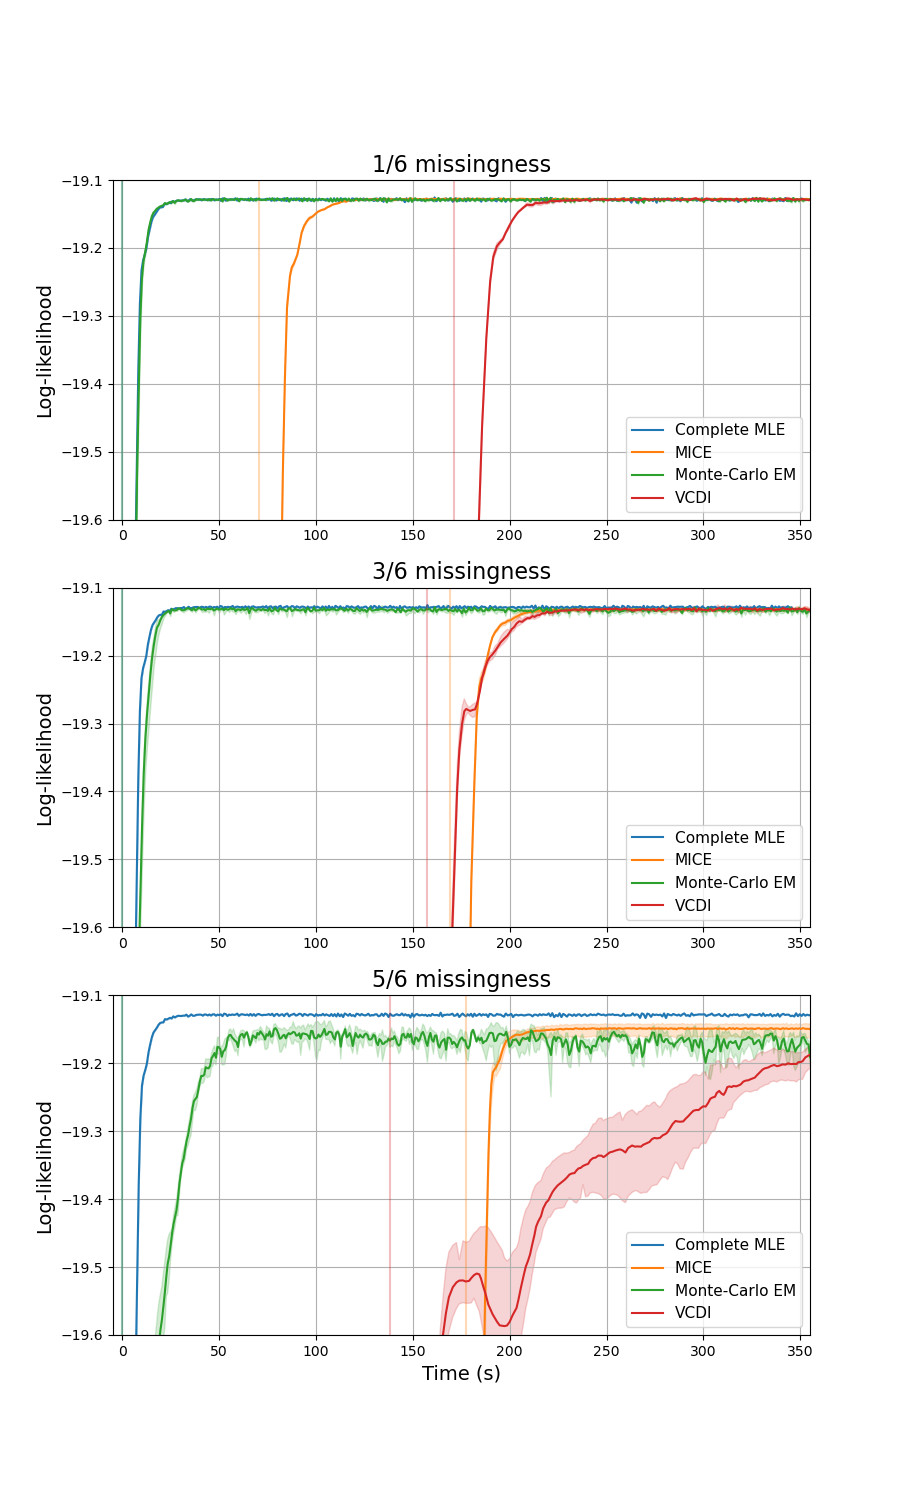

(-5.0, 355.0)

In [16]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 15))
# axes = [axes]
for i, g in enumerate([1, 3, 5]):
    stats = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    v_lines = {}
    for exp, metrics in stats.items():
        for j in range(len(metrics['train_time'])):
            metrics['train_time'][j] = np.cumsum(metrics['train_time'][j])
        mean_time_cum_sum = np.mean(np.stack(metrics['train_time']), axis=0)
        for j in range(len(metrics['train_time'])):
            metrics['train_time'][j] = mean_time_cum_sum.copy()
            
        if 'init_time' in metrics['init']:
            for j in range(len(metrics['init']['init_time'])):
                metrics['init']['init_time'][j] = np.cumsum(metrics['init']['init_time'][j])
            mean_init_time_cum_sum = np.mean(np.stack(metrics['init']['init_time']), axis=0)
            init_time = np.sum(mean_init_time_cum_sum)
            for j in range(len(metrics['train_time'])):
                metrics['train_time'][j] += init_time

            v_lines[exp] = init_time
        else:
            v_lines[exp] = None

    if i in (2,):
        xlabel = 'Time (s)'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='train_time',
                    y_metric_keys=('val_log_lik',),  
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.6, -19.1))

axes[0].set_xlim(left=-5, right=355)
axes[1].set_xlim(left=-5, right=355)
axes[2].set_xlim(left=-5, right=355)

#### Log-likelihood vs # var. model evaluations

In [13]:
suite = {
    'VCDI MI5': 'fa_variational_cdi_mi5',
    'pre-VCDI MI5 1mis 1gibbs': 'fa_pretrained_var_cdi_mi5_1mis_1gibbs',
    'pre-VCDI MI5 1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
    'pre-VCDI MI5 all-miss 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
    'pre-VCDI MI1 1mis 1gibbs': 'fa_pretrained_var_cdi_mi1_1mis_1gibbs',
    'pre-VCDI MI1 1mis 3gibbs': 'fa_pretrained_var_cdi_mi1_1mis_3gibbs',
    'pre-VCDI MI1 all-miss 1gibbs': 'fa_pretrained_var_cdi_mi1_all_mis_1gibbs',
}

##### Single experiment

<IPython.core.display.Javascript object>


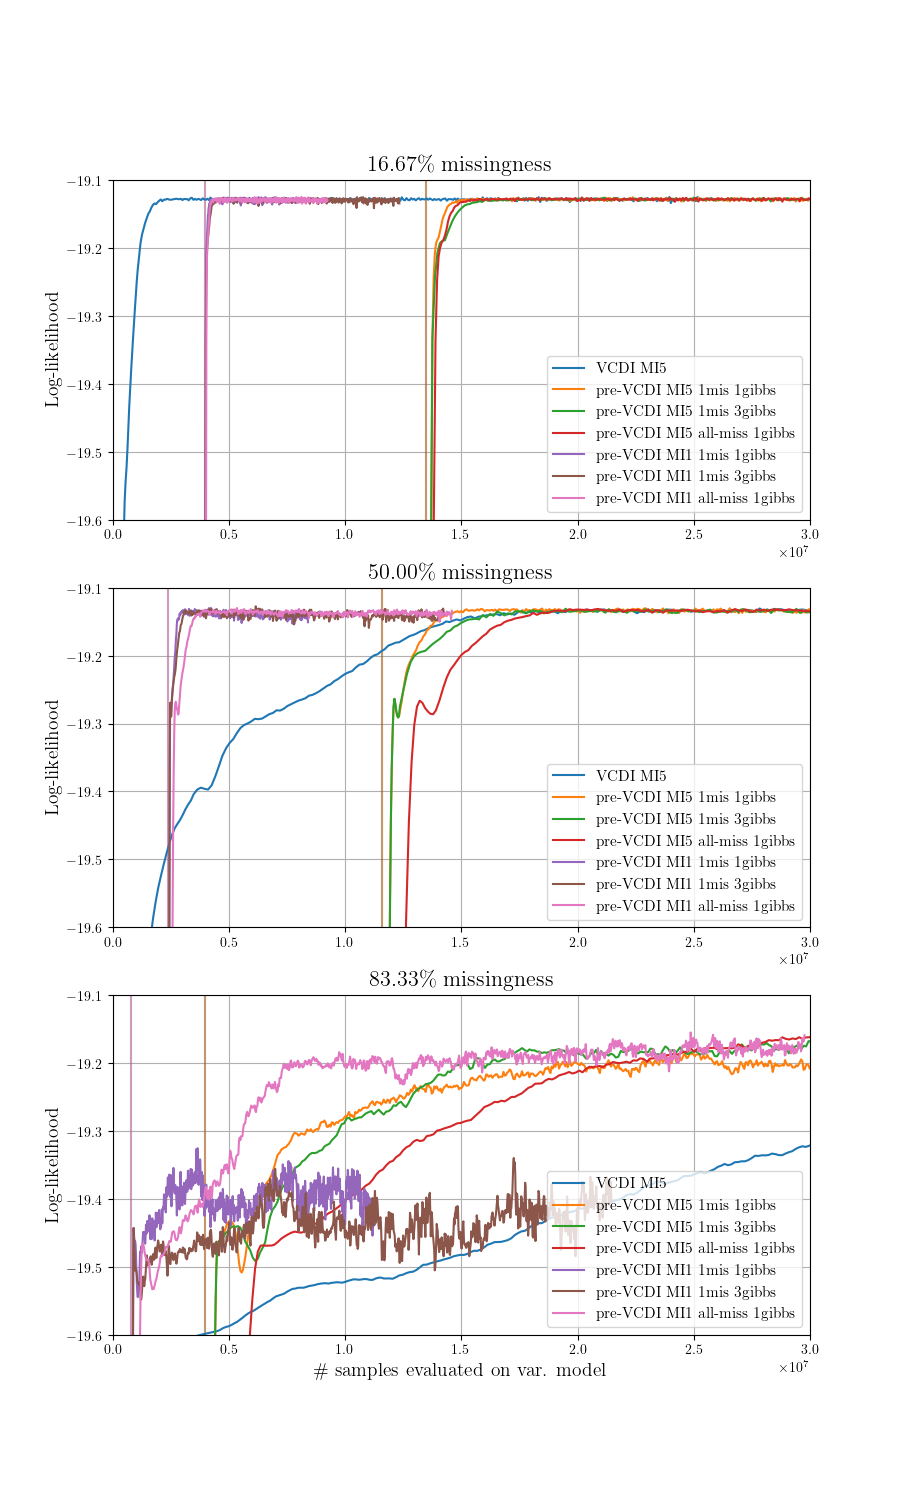

(-10.0, 30000000.0)

In [14]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 15))
# axes = [axes]
for i, g in enumerate([1, 3, 5]):
    stats = read_suite_stats_with_init(group=g, suite=suite, seed=exp_seed_keys[0])
    v_lines = {}
    for exp, metrics in stats.items():
        metrics['cum_var_calls'] = np.cumsum(metrics['cum_var_calls'])
        if 'cum_var_calls' in metrics['init']:
            init_calls = np.sum(metrics['init']['cum_var_calls'])
            metrics['cum_var_calls'] += init_calls
            v_lines[exp] = init_calls
        else:
            v_lines[exp] = None
    
    if i in (2,):
        xlabel = '\# samples evaluated on var. model'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_comparison(axes[i], stats, 
                    x_metric_key='cum_var_calls',
                    y_metric_keys=('val_log_lik',),  
                    err_keys=(None,),
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.6, -19.1))

axes[0].set_xlim(left=-10, right=3e7)
axes[1].set_xlim(left=-10, right=3e7)
axes[2].set_xlim(left=-10, right=3e7)

##### Avg. over seeds

<IPython.core.display.Javascript object>


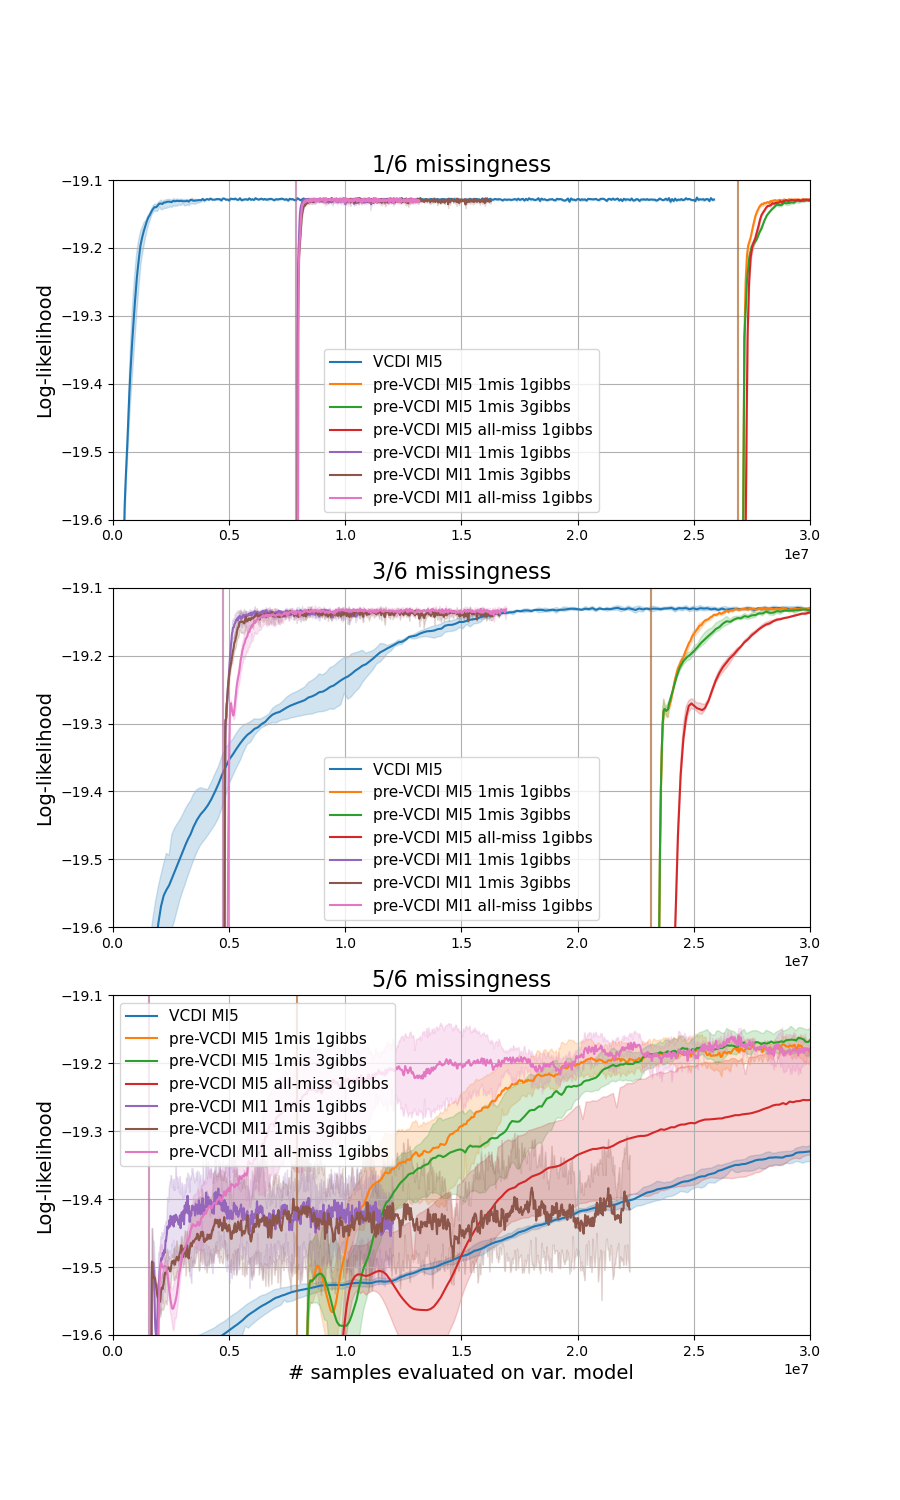

(-10.0, 30000000.0)

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 15))
# axes = [axes]
for i, g in enumerate([1, 3, 5]):
    stats = read_suite_stats_with_init_all_seeds(group=g, suite=suite)
    v_lines = {}
    for exp, metrics in stats.items():
        for j in range(len(metrics['cum_var_calls'])):
            metrics['cum_var_calls'][j] = np.cumsum(metrics['cum_var_calls'][j])
        mean_call_cum_sum = np.mean(np.stack(metrics['cum_var_calls']), axis=0)
        for j in range(len(metrics['cum_var_calls'])):
            metrics['cum_var_calls'][j] = mean_call_cum_sum.copy()
        
        if 'cum_var_calls' in metrics['init']:
            for j in range(len(metrics['init']['cum_var_calls'])):
                metrics['init']['cum_var_calls'][j] = np.cumsum(metrics['init']['cum_var_calls'][j])
            mean_init_calls_cum_sum = np.mean(np.stack(metrics['init']['cum_var_calls']), axis=0)
            init_calls = np.sum(mean_init_calls_cum_sum)
            for j in range(len(metrics['cum_var_calls'])):
                metrics['cum_var_calls'][j] += init_calls

            v_lines[exp] = init_calls
        else:
            v_lines[exp] = None
    
    if i in (2,):
        xlabel = '\# samples evaluated on var. model'
    else:
        xlabel = None
    axes[i].set_title(label=f'{g/6*100:.2f}\% missingness', fontdict={'fontsize': 16})
    plot_seaborn_comparison(axes[i], stats, 
                    x_metric_key='cum_var_calls',
                    y_metric_keys=('val_log_lik',),  
                    v_lines=v_lines,
                    xlabel=xlabel,
                    ylabel='Log-likelihood', 
                    ylim=(-19.6, -19.1))

axes[0].set_xlim(left=-10, right=3e7)
axes[1].set_xlim(left=-10, right=3e7)
axes[2].set_xlim(left=-10, right=3e7)

### Var. model pretraining learning curve

In [59]:
suite = {
#     'Var': 'var_pretraining_mi5',
    'Var test': 'var_pretraining_test2',
}

<IPython.core.display.Javascript object>


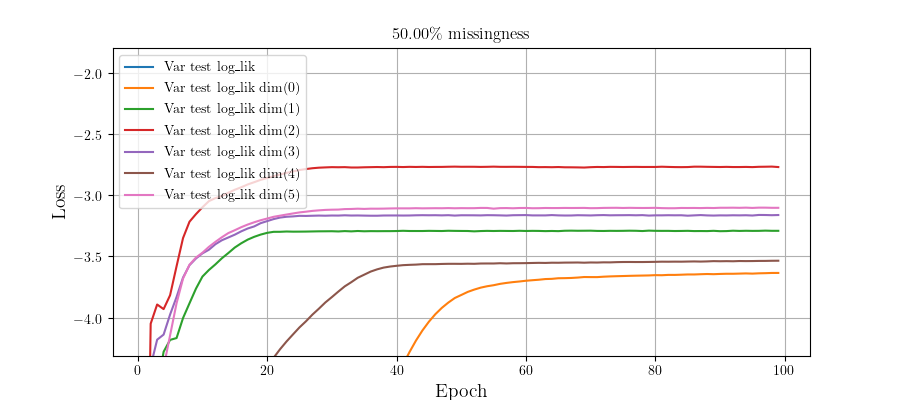

In [60]:
y_metrics = ('train_log_lik',#)
            'train_log_lik_0',
            'train_log_lik_1',
            'train_log_lik_2',
            'train_log_lik_3',
            'train_log_lik_4',
            'train_log_lik_5')
err_metrics = (None, None, None, None, None, None, None)
metric_labels = ('log\_lik',#)
                 'log\_lik dim(0)',
                 'log\_lik dim(1)',
                 'log\_lik dim(2)',
                 'log\_lik dim(3)',
                 'log\_lik dim(4)',
                 'log\_lik dim(5)',)

fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(9, 4))
axes = [axes]
for i, g in enumerate([3]):
    axes[i].set(title=f'{g/6*100:.2f}\% missingness')
    stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')
    
    plot_comparison(axes[i], stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=y_metrics,  
                    err_keys=err_metrics,
                    metric_labels=metric_labels,
                    xlabel='Epoch',
                    ylabel='Loss', 
                    ylim=None,
                    colors_instead_styles=True)

    axes[i].legend(loc='upper left')

### Regression fn learning curve

In [22]:
suite = {
    'Regression': 'mean_regression_fn',
}

<IPython.core.display.Javascript object>


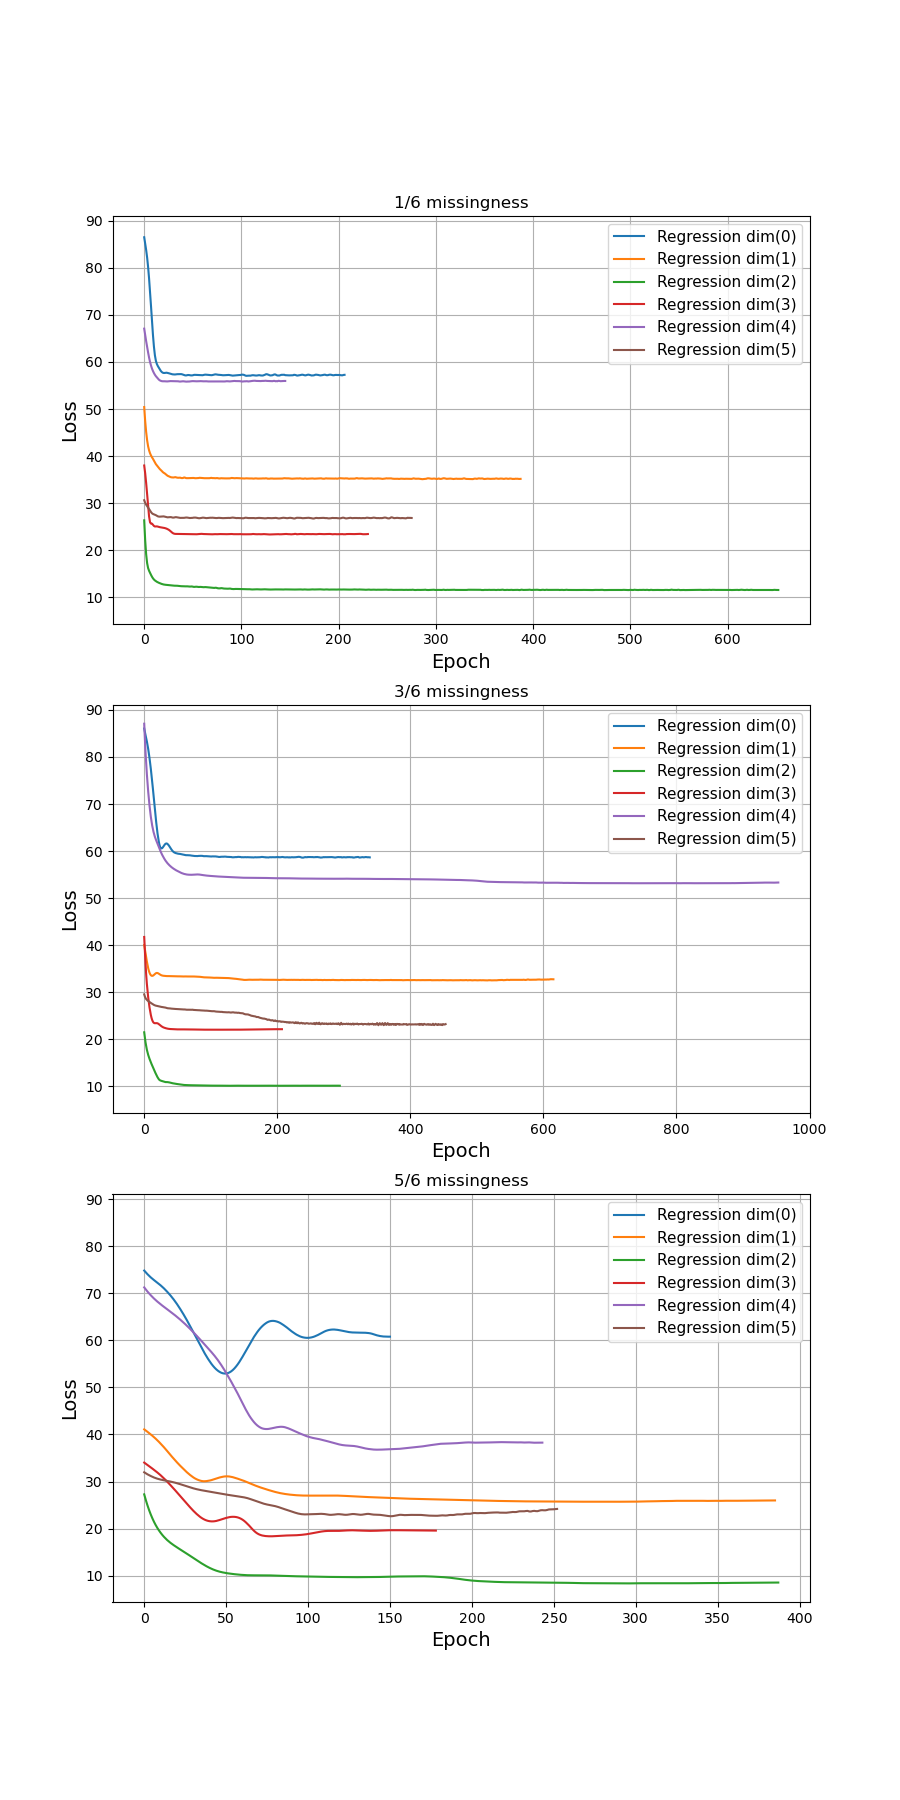

In [23]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 18))
for i, g in enumerate([1, 3, 5]):
    axes[i].set(title=f'{g}/6 missingness')
    # Read stats for all dimensions
    all_stats = {}
    for j in range(6):
        stats=read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary{}.csv'.format(j))
        stats = {
            f'{k} dim({j})':v
            for k, v in stats.items()
        }
        all_stats.update(stats)

    plot_comparison(axes[i], all_stats, 
                    x_metric_key='curr_epoch',
                    y_metric_keys=('val_loss',),  
                    err_keys=(None,),
                    xlabel='Epoch',
                    ylabel='Loss', 
                    ylim=None)


### Rejected samples analysis

In [24]:
# suite = {
#     'Complete MLE': 'fa_complete_data',
#     'Emp. imp. base MI5': 'fa_empirical_sample_baseline_mi5',
#     'Reg. imp. base': 'fa_regression_baseline',
#     'MICE base': 'fa_mice_baseline',
#     'EM (indep)': 'fa_em_indep',
#     'EM (joint)': 'fa_em_joint',
#     'CDI MI5': 'fa_exact_gibbs_posterior_cdi_mi5',
#     'VCDI MI5': 'fa_variational_cdi_mi5',
#     'pre-VCDI MI5 1mis 1gibbs': 'fa_pretrained_var_cdi_1mis_1gibbs',
#     'pre-VCDI MI5 1mis 3gibbs': 'fa_pretrained_var_cdi_1mis_3gibbs',
#     'pre-VCDI MI5 all-miss 1gibbs': 'fa_pretrained_var_cdi_all_mis_1gibbs',
# }

In [25]:
# fig, axes = plt.subplots(nrows=3, ncols=1, sharey=True, figsize=(9, 18))
# for i, g in enumerate([1, 3, 5]):
#     stats = read_suite_stats(group=g, suite=suite, seed=exp_seed_keys[0], filename='summary.csv')

#     axes[i].set(title=f'{g}/6 missingness')
#     plot_comparison(axes[i], stats, 
#                     x_metric_key='curr_epoch',
#                     y_metric_keys=('imp_rejected',),  
#                     err_keys=(None,),
#                     xlabel='Epoch',
#                     ylabel='Rejected samples',
#                     ylim=None)


### Train epoch time analysis

In [26]:
suite = {
    'Complete MLE': 'fa_complete_data',
    'Emp. imp. base MI5': 'fa_empirical_sample_baseline_mi5',
    'Reg. imp. base': 'fa_regression_baseline',
    'MICE base': 'fa_mice_baseline_mi5',
    'EM (indep)': 'fa_em_indep',
    'EM (joint)': 'fa_em_joint',
    'CDI MI5': 'fa_exact_gibbs_posterior_cdi_mi5',
    'VCDI MI5': 'fa_variational_cdi_mi5',
    'pre-VCDI MI5 1mis 1gibbs': 'fa_pretrained_var_cdi_mi5_1mis_1gibbs',
    'pre-VCDI MI5 1mis 3gibbs': 'fa_pretrained_var_cdi_mi5_1mis_3gibbs',
    'pre-VCDI MI5 all-miss 1gibbs': 'fa_pretrained_var_cdi_mi5_all_mis_1gibbs',
}

<IPython.core.display.Javascript object>


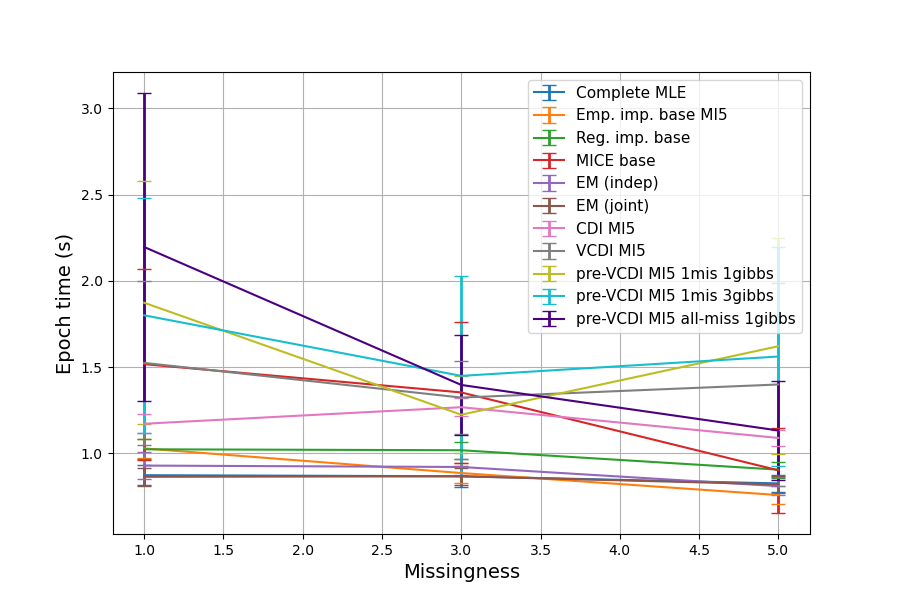

In [27]:
stats = read_all_suite_stats([1,3,5], suite, seed=exp_seed_keys[0], filename='summary.csv')
stats = collate_stats(stats)
fig, axes = plt.subplots(nrows=1, ncols=1, sharey=True, figsize=(9, 6))
plot_comparison(axes, stats, 
                x_metric_key='group',
                y_metric_keys=('train_time mean',),  
                err_keys=('train_time std',),
                xlabel='Missingness',
                ylabel='Epoch time (s)',
                ylim=None)
